# Study 1

Angle: 0° | Measured Peak: 666.50 keV ± 14.00 keV
Angle: 30° | Measured Peak: 566.50 keV ± 12.00 keV
Angle: 45° | Measured Peak: 481.50 keV ± 10.00 keV
Angle: 60° | Measured Peak: 401.50 keV ± 8.00 keV
Angle: 90° | Measured Peak: 289.50 keV ± 5.00 keV


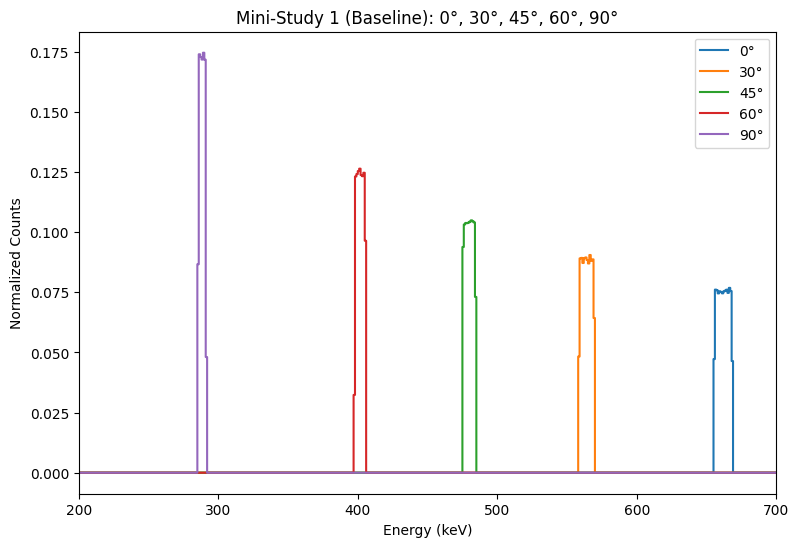

In [101]:
#!/usr/bin/env python3
"""
Mini-Study 1: Baseline Simulation (Enhanced with FWHM)
------------------------------------------------------
We simulate single-scattering events from a Cs-137 source (662 keV) onto 
a single aluminum rod. We calculate the FWHM as the uncertainty for each peak.
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import csv

# Create directory if it doesn't exist
os.makedirs('data/simulation/study1', exist_ok=True)

# ... [Previous code remains the same until the file saving part in mini_study_1_baseline function] ...

def mini_study_1_baseline(
    num_photons=100000, 
    angles_deg=[0, 30, 45, 60, 90]
):
    """
    [Previous docstring remains the same]
    """
    angles_rad = np.radians(angles_deg)
    results = {}

    # For each angle, compute a 'delta-like' scattered energy, then uniformly smear it
    for angle_deg, angle_rad in zip(angles_deg, angles_rad):
        E_scattered = compton_scattered_energy(E0, angle_rad)
        
        # Minimal uniform spread (~1%):
        tiny_spread = 0.01 * E_scattered
        energies = np.random.uniform(E_scattered - tiny_spread, 
                                     E_scattered + tiny_spread, 
                                     num_photons)
        
        results[angle_deg] = energies

    # Plot all angles on the same figure
    plt.figure(figsize=(9, 6))
    bin_edges = np.arange(0, 801, 1)  # 0 to 800 keV in 1 keV steps

    for angle_deg in angles_deg:
        # Create histogram for each angle
        energies = results[angle_deg]
        counts, edges = np.histogram(energies, bins=bin_edges)
        centers = 0.5 * (edges[:-1] + edges[1:])

        # Normalize so each angle's spectrum can be compared
        norm = counts.sum() if counts.sum() > 0 else 1
        normalized_counts = counts / norm

        # Save data to CSV file
        filename = f'data/simulation/study1/angle_{angle_deg}_deg.csv'
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Energy (keV)', 'Counts'])  # Header
            for energy, count in zip(centers, normalized_counts):
                writer.writerow([energy, count])

        plt.step(centers, normalized_counts, label=f"{angle_deg}°", where='mid')

        # Find the peak (most frequent bin center)
        max_bin_index = np.argmax(counts)
        peak_energy = centers[max_bin_index]

        # Calculate FWHM as uncertainty
        fwhm = calculate_fwhm(counts, edges)

        # Print out measured peak and FWHM
        print(f"Angle: {angle_deg}° | Measured Peak: {peak_energy:.2f} keV ± {fwhm:.2f} keV")

    plt.title("Mini-Study 1 (Baseline): 0°, 30°, 45°, 60°, 90°")
    plt.xlim(200, 700)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Counts")
    plt.legend()
    plt.show()

    return results


if __name__ == "__main__":
    # Example usage
    mini_study_1_baseline(
        num_photons=100000,
        angles_deg=[0, 30, 45, 60, 90]
    )


RMS Deviation: 0.3466


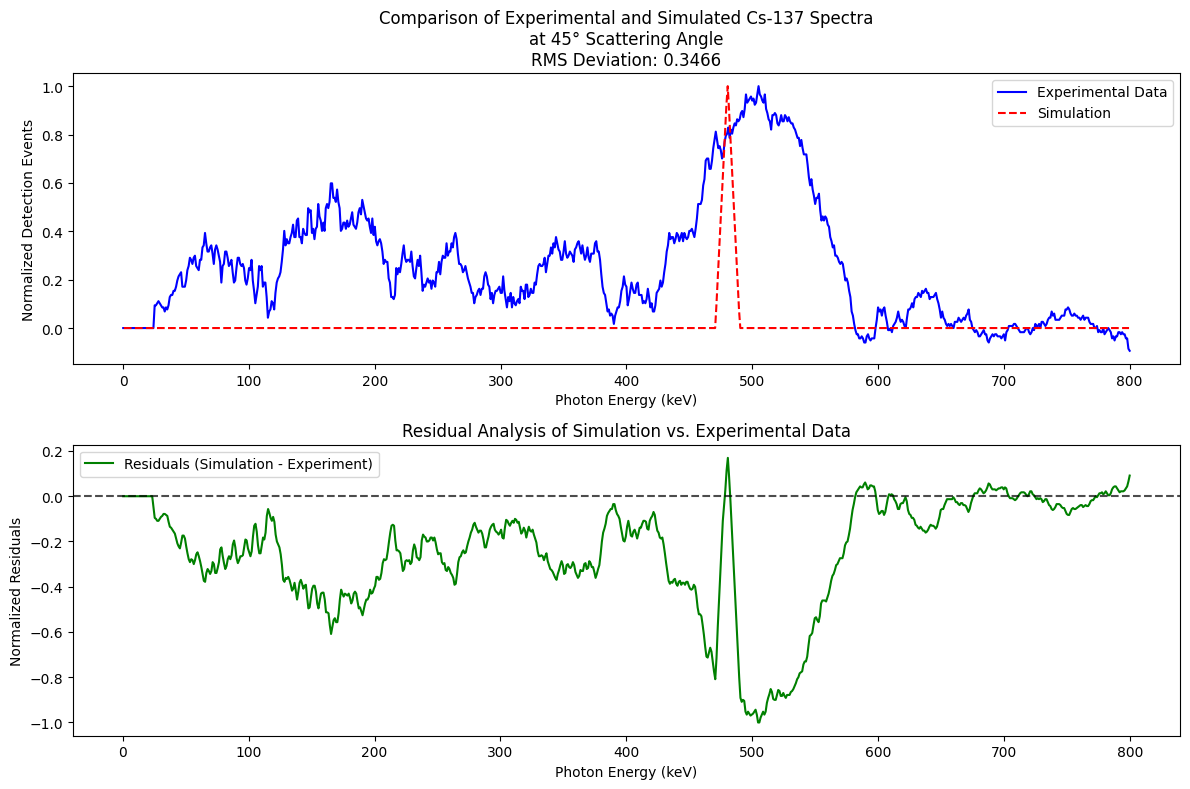

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Experimental Data ---
def load_and_smooth_experiment_data(window_size=10):
    """
    Load experimental data and smooth using a rolling average.
    :param window_size: Number of bins for smoothing.
    :return: Smoothed experimental data (with aluminum - no aluminum).
    """
    # Load experimental data
    with_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-with-shielding.csv')
    no_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-no-aluminium-with-shielding.csv')
    
    # Sort data and reset index
    with_al_data = with_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    no_al_data = no_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    
    # Subtract background
    subtracted_data = with_al_data.copy()
    subtracted_data['Events N'] = with_al_data['Events N'] - no_al_data['Events N']
    
    # Smooth data
    subtracted_data['Events N'] = subtracted_data['Events N'].rolling(window=window_size, center=True).mean()
    
    # Limit data range to 0–800 keV
    subtracted_data = subtracted_data[subtracted_data['Energy E / keV'] <= 800]

    # Replace NaN values with zeros
    subtracted_data = subtracted_data.fillna(0)
    
    return subtracted_data

# --- Load Simulation Data ---
def load_simulation_data():
    """
    Load simulation data from file.
    :return: Simulation bin centers and normalized counts.
    """
    # Load simulation data
    sim_data = pd.read_csv('data/simulation/study1/angle_45_deg.csv')
    
    # Extract bin centers and counts
    bin_centers = sim_data['Energy (keV)'].values
    sim_data['Counts'] = sim_data['Counts'].rolling(window=10, center=True).mean()
    sim_data = sim_data.fillna(0)

    counts = sim_data['Counts'].values
    
    # Normalize counts
    counts_normalized = counts / np.max(counts)
    
    return bin_centers, counts_normalized

def calculate_rms_deviation(experimental_counts, simulation_counts):
    """
    Calculate RMS deviation between experimental and simulation data.
    """
    squared_diff = (experimental_counts - simulation_counts) ** 2
    rms = np.sqrt(np.mean(squared_diff))
    return rms

# --- Plotting ---
def plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts):
    """
    Plot experimental data, simulated data, and their difference.
    """
    # Interpolate experimental data to align with simulation bins
    experimental_counts = np.interp(simulation_bins, experiment_data['Energy E / keV'], experiment_data['Events N'])
    
    # Normalize both datasets
    experimental_counts_normalized = experimental_counts / np.max(experimental_counts)
    simulation_counts_normalized = simulation_counts / np.max(simulation_counts)
    
    # Calculate RMS deviation
    rms_deviation = calculate_rms_deviation(experimental_counts_normalized, simulation_counts_normalized)
    print(f"RMS Deviation: {rms_deviation:.4f}")
    
    # Calculate the difference (simulation - experiment)
    difference = simulation_counts_normalized - experimental_counts_normalized
    
    # Plot experiment and simulation
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(experiment_data['Energy E / keV'], experiment_data['Events N'] / np.max(experiment_data['Events N']),
             label='Experimental Data', color='blue')
    plt.plot(simulation_bins, simulation_counts_normalized, label='Simulation', color='red', linestyle='--')
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Detection Events')
    plt.title(f'Comparison of Experimental and Simulated Cs-137 Spectra\nat 45° Scattering Angle\nRMS Deviation: {rms_deviation:.4f}')
    plt.legend()
    
    # Plot difference
    plt.subplot(2, 1, 2)
    plt.plot(simulation_bins, difference, 
             label='Residuals (Simulation - Experiment)', color='green')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Residuals')
    plt.title('Residual Analysis of Simulation vs. Experimental Data')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Load and smooth experimental data
    experiment_data = load_and_smooth_experiment_data(window_size=50)
    
    # Load simulation data
    simulation_bins, simulation_counts = load_simulation_data()
    
    # Plot results
    plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts)


# Study 2

Data for 30° saved to data/simulation/study2\simulation_angle_30deg.csv.
Data for 45° saved to data/simulation/study2\simulation_angle_45deg.csv.
Data for 60° saved to data/simulation/study2\simulation_angle_60deg.csv.
Data for 90° saved to data/simulation/study2\simulation_angle_90deg.csv.


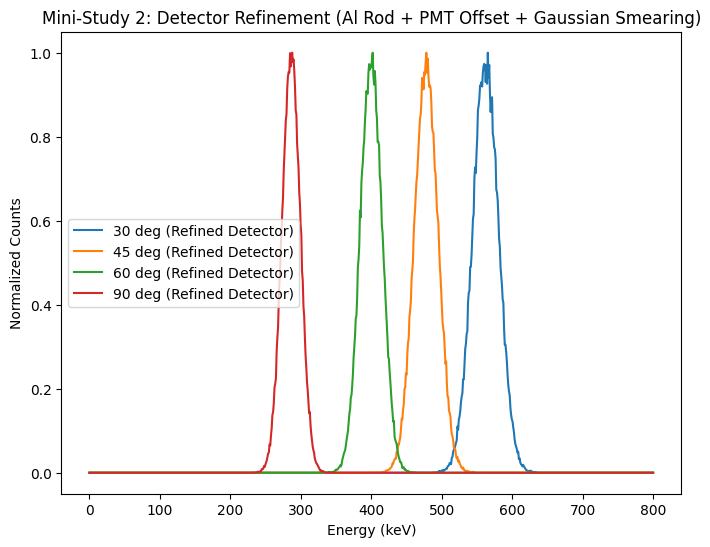

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from compton_helpers import (
    E0,                      # 662 keV for Cs-137
    sample_theta_klein_nishina,  
    compton_scattered_energy,
    gaussian_energy_smearing,
    plot_spectrum
)

def save_simulation_data(angle_deg, energy_bins, counts, directory="data/simulation/study2"):
    """
    Save simulation data to a CSV file.
    :param angle_deg: Scattering angle in degrees.
    :param energy_bins: Array of energy bin centers.
    :param counts: Array of normalized counts.
    :param directory: Directory to save the file.
    """
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Create a DataFrame
    data = pd.DataFrame({
        "Energy (keV)": energy_bins,
        "Counts": counts
    })
    
    # Save to CSV
    file_path = os.path.join(directory, f"simulation_angle_{angle_deg}deg.csv")
    data.to_csv(file_path, index=False)
    print(f"Data for {angle_deg}° saved to {file_path}.")

def mini_study_2_detector(num_photons=100000, 
                          angles_deg=[30, 90, 135],
                          photoelectric_frac=0.05,
                          FWHM_at_662=0.07, 
                          PMT_offset=2.0,
                          save_data=True):
    """
    Refined simulation of single-scatter events from a Cs-137 source 
    on an aluminum rod, now including:
      - Fractional photoelectric absorption in the rod (photoelectric_frac)
      - Realistic detector resolution (Gaussian smearing with energy-dependence)
      - A PMT offset (energy lost before detection or calibration shift)

    :param num_photons:        Number of photons to simulate per angle
    :param angles_deg:         Scattering angles in degrees
    :param photoelectric_frac: Fraction of photons that undergo photoelectric 
                               absorption in the Al rod (no scattered photon)
    :param FWHM_at_662:        e.g., 0.07 => 7% FWHM at 662 keV
    :param PMT_offset:         (keV) offset simulating PMT window loss or shift
    :param save_data:          Save simulation data to CSV.
    :return: Dictionary {angle: array_of_energies}
    """
    angles_rad = np.radians(angles_deg)
    results = {}

    for angle_deg, angle_rad in zip(angles_deg, angles_rad):
        # 1) SINGLE-SCATTER GEOMETRY: 
        #    We treat the Cs-137 source as point-like, 
        #    and photons scatter in the aluminum rod at a fixed angle.

        # Fraction that survives photoelectric absorption
        random_draws = np.random.rand(num_photons)
        is_compton = (random_draws > photoelectric_frac)

        # 2) Compute the ideal Compton-scattered energy for each photon 
        E_scattered_ideal = compton_scattered_energy(E0, angle_rad)

        # 3) Keep only those photons that are not photoelectrically absorbed
        E_scattered = E_scattered_ideal * is_compton

        # 4) Add a tiny uniform spread around E_scattered (±1%)
        tiny_spread = 0.01 * E_scattered
        energies_rod = np.random.uniform(
            E_scattered - tiny_spread,
            E_scattered + tiny_spread
        )

        # Remove zeros (photons lost in photoelectric events)
        energies_rod = energies_rod[energies_rod > 0.0]

        # 5) PMT offset: subtract a fixed keV offset (simulating, e.g., 
        #    window absorption or calibration shift). Clip at 0 keV.
        energies_measured = energies_rod - PMT_offset
        energies_measured[energies_measured < 0] = 0.0

        # 6) Apply Gaussian smearing for the detector resolution. 
        energies_smeared = gaussian_energy_smearing(
            energies_measured, 
            FWHM_at_662=FWHM_at_662
        )

        # Bin the data
        bins = np.linspace(0, 800, 800)  # Energy range limited to 0–800 keV
        hist, bin_edges = np.histogram(energies_smeared, bins=bins)
        
        # Normalize histogram
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        hist_normalized = hist / np.max(hist)  # Normalize counts

        # Save the data if required
        if save_data:
            save_simulation_data(angle_deg, bin_centers, hist_normalized)

        # Save results for plotting
        results[angle_deg] = (bin_centers, hist_normalized)

    # PLOT
    plt.figure(figsize=(8, 6))
    for angle_deg in angles_deg:
        bin_centers, hist_normalized = results[angle_deg]
        plt.plot(bin_centers, hist_normalized, label=f"{angle_deg} deg (Refined Detector)")
    
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Counts")
    plt.title("Mini-Study 2: Detector Refinement (Al Rod + PMT Offset + Gaussian Smearing)")
    plt.legend()
    plt.show()
    
    return results


if __name__ == "__main__":
    # Example usage
    mini_study_2_detector(
        num_photons=100000, 
        angles_deg=[30, 45, 60, 90],
        photoelectric_frac=0.05, 
        FWHM_at_662=0.07,
        PMT_offset=2.0
    )


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Experimental Data ---
def load_and_smooth_experiment_data(window_size=10):
    """
    Load experimental data and smooth using a rolling average.
    :param window_size: Number of bins for smoothing.
    :return: Smoothed experimental data (with aluminum - no aluminum).
    """
    # Load experimental data
    with_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-with-shielding.csv')
    no_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-no-aluminium-with-shielding.csv')
    
    # Sort data and reset index
    with_al_data = with_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    no_al_data = no_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    
    # Subtract background
    subtracted_data = with_al_data.copy()
    subtracted_data['Events N'] = with_al_data['Events N'] - no_al_data['Events N']
    
    # Smooth data
    subtracted_data['Events N'] = subtracted_data['Events N'].rolling(window=window_size, center=True).mean()
    
    # Limit data range to 0–800 keV
    subtracted_data = subtracted_data[subtracted_data['Energy E / keV'] <= 800]

    # Replace NaN values with zeros
    subtracted_data = subtracted_data.fillna(0)
    
    return subtracted_data

# --- Load Simulation Data ---
def load_simulation_data():
    """
    Load simulation data from file.
    :return: Simulation bin centers and normalized counts.
    """
    # Load simulation data
    sim_data = pd.read_csv('data/simulation/simulation_angle_45deg.csv')
    
    # Extract bin centers and counts
    bin_centers = sim_data['Energy (keV)'].values
    sim_data['Counts'] = sim_data['Counts'].rolling(window=10, center=True).mean()
    sim_data = sim_data.fillna(0)

    counts = sim_data['Counts'].values
    
    # Normalize counts
    counts_normalized = counts / np.max(counts)
    
    return bin_centers, counts_normalized

def calculate_rms_deviation(experimental_counts, simulation_counts):
    """
    Calculate RMS deviation between experimental and simulation data.
    """
    squared_diff = (experimental_counts - simulation_counts) ** 2
    rms = np.sqrt(np.mean(squared_diff))
    return rms

# --- Plotting ---
def plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts):
    """
    Plot experimental data, simulated data, and their difference.
    """
    # Interpolate experimental data to align with simulation bins
    experimental_counts = np.interp(simulation_bins, experiment_data['Energy E / keV'], experiment_data['Events N'])
    
    # Normalize both datasets
    experimental_counts_normalized = experimental_counts / np.max(experimental_counts)
    simulation_counts_normalized = simulation_counts / np.max(simulation_counts)
    
    # Calculate RMS deviation
    rms_deviation = calculate_rms_deviation(experimental_counts_normalized, simulation_counts_normalized)
    print(f"RMS Deviation: {rms_deviation:.4f}")
    
    # Calculate the difference (simulation - experiment)
    difference = simulation_counts_normalized - experimental_counts_normalized
    
    # Plot experiment and simulation
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(experiment_data['Energy E / keV'], experiment_data['Events N'] / np.max(experiment_data['Events N']),
             label='Experimental Data', color='blue')
    plt.plot(simulation_bins, simulation_counts_normalized, label='Simulation', color='red', linestyle='--')
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Detection Events')
    plt.title(f'Comparison of Experimental and Simulated Cs-137 Spectra\nat 45° Scattering Angle\nRMS Deviation: {rms_deviation:.4f}')
    plt.legend()
    
    # Plot difference
    plt.subplot(2, 1, 2)
    plt.plot(simulation_bins, difference, 
             label='Residuals (Simulation - Experiment)', color='green')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Residuals')
    plt.title('Residual Analysis of Simulation vs. Experimental Data')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("data/simulation/study2/mini_study_2.png", dpi=300)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Load and smooth experimental data
    experiment_data = load_and_smooth_experiment_data(window_size=50)
    
    # Load simulation data
    simulation_bins, simulation_counts = load_simulation_data()
    
    # Plot results
    plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts)


FileNotFoundError: [Errno 2] No such file or directory: 'data/simulation/simulation_angle_45deg.csv'

# Study 3

Saved spectrum data to data/simulation/study3\simulation_angle_45deg.csv


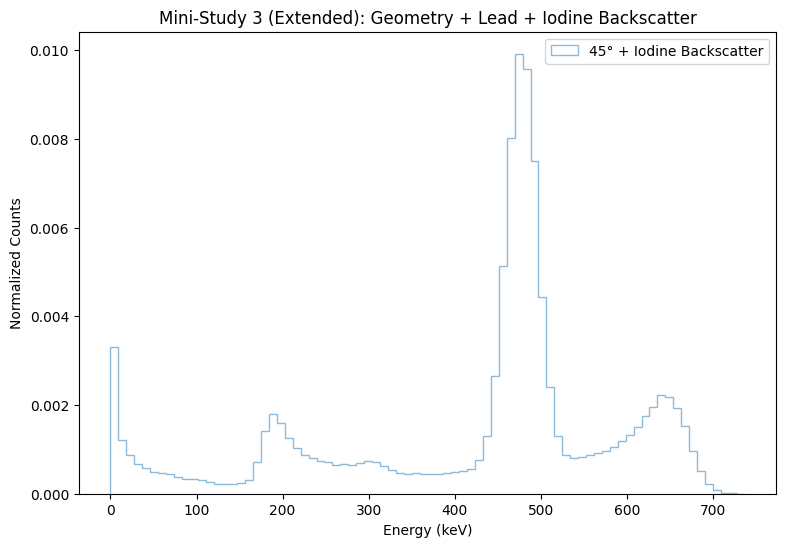

In [70]:
#!/usr/bin/env python3
"""
Mini-Study 3 (Extended): Geometry Refinement with Lead Pass-Through
-------------------------------------------------------------------
Now includes a simplified model for internal backscatter in the NaI(Tl) detector.

Key changes:
- Part F: Each photon has a probability `p_backscatter` of doing one Compton 
  scatter in the iodine. A fraction of those might "escape", leaving a 
  backscatter peak in the deposited energy.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Same helpers as before:
from compton_helpers import (
    E0,
    sample_theta_klein_nishina,      # for random scattering angles
    compton_scattered_energy,        # Compton formula
    gaussian_energy_smearing,        # Detector resolution
    plot_spectrum                    # Quick histogram plotting
)

def simulate_iodine_backscatter(energies_in, p_backscatter=0.1, p_escape=0.5):
    """
    Simplified model of internal backscatter in the NaI detector.
    """
    # Copy the input energies so we can modify them
    energies_out = np.array(energies_in, copy=True)
    n_photons = len(energies_out)

    # Determine which photons will attempt a backscatter
    backscatter_flags = np.random.rand(n_photons) < p_backscatter

    # For those that do backscatter, pick a scattering angle from the KN distribution:
    n_bs = np.count_nonzero(backscatter_flags)
    if n_bs > 0:
        E_in_bs = energies_out[backscatter_flags]  
        thetas = sample_theta_klein_nishina(E0, size=n_bs)  
        scattered_E = compton_scattered_energy(E_in_bs, thetas)

        escapes = np.random.rand(n_bs) < p_escape
        deposit_escape = E_in_bs - scattered_E
        deposit_escape[deposit_escape < 0] = 0  
        deposit_full = E_in_bs  
        deposit_total = np.where(escapes, deposit_escape, deposit_full)
        energies_out[backscatter_flags] = deposit_total
    
    return energies_out

def save_spectrum_data(energies, angle, output_dir='data/simulation/study3'):
    """
    Save spectrum data to CSV file.
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create histogram data
    hist, bin_edges = np.histogram(energies, bins=800, range=(0, 800))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Create DataFrame
    df = pd.DataFrame({
        'Energy (keV)': bin_centers,
        'Counts': hist
    })
    
    # Save to CSV
    filename = os.path.join(output_dir, f'simulation_angle_{angle}deg.csv')
    df.to_csv(filename, index=False)
    print(f"Saved spectrum data to {filename}")

def mini_study_3_geometry_lead(num_photons=100000,
                               angles_deg=[30, 90, 135],
                               FWHM_at_662=0.07,
                               PMT_offset=2.0,
                               angle_uncertainty_deg=1.0,
                               fraction_background=0.1,
                               lead_thickness_cm=1.0,
                               mu_lead=1.2,
                               p_backscatter=0.1,
                               p_escape=0.5):
    """
    Extended geometry refinement function with data saving capability.
    """
    angles_rad = np.radians(angles_deg)
    results = {}
    
    transmission_prob = np.exp(-mu_lead * lead_thickness_cm)

    for angle_deg, angle_rad in zip(angles_deg, angles_rad):
        # Part A: Main single-scatter
        angle_dev = np.random.normal(0, np.radians(angle_uncertainty_deg), num_photons)
        actual_angles = angle_rad + angle_dev
        E_scattered_main = compton_scattered_energy(E0, actual_angles)
        
        # Part B: Background scattering
        n_bg = int(fraction_background * num_photons)
        thetas_bg = sample_theta_klein_nishina(E0, size=n_bg)
        E_scattered_bg = compton_scattered_energy(E0, thetas_bg)
        E_combined = np.concatenate((E_scattered_main, E_scattered_bg), axis=0)
        
        # Part C: Lead pass-through
        fraction_lead_pool = 0.2
        n_lead_attempt = int(fraction_lead_pool * num_photons)
        n_lead_pass = int(transmission_prob * n_lead_attempt)
        thetas_lead = sample_theta_klein_nishina(E0, size=n_lead_pass)
        E_scattered_lead = compton_scattered_energy(E0, thetas_lead)
        E_final = np.concatenate((E_combined, E_scattered_lead), axis=0)
        
        # Part D: Multi-scatter spread
        tiny_spread = 0.01 * E_final
        energies_before_detector = E_final + np.random.uniform(-tiny_spread, tiny_spread)
        
        # Part E: PMT offset
        energies_measured = energies_before_detector - PMT_offset
        energies_measured[energies_measured < 0] = 0.0
        
        # Part F: Iodine backscatter
        energies_after_iodine = simulate_iodine_backscatter(
            energies_measured,
            p_backscatter=p_backscatter,
            p_escape=p_escape
        )
        
        # Part G: Detector resolution
        energies_smeared = gaussian_energy_smearing(energies_after_iodine, FWHM_at_662)
        
        # Save results and spectrum data
        results[angle_deg] = energies_smeared
        save_spectrum_data(energies_smeared, angle_deg)
    
    # Plot results
    plt.figure(figsize=(9,6))
    for angle_deg in angles_deg:
        energies = results[angle_deg]
        plot_spectrum(energies,
                      bins=80,
                      label=f"{angle_deg}° + Iodine Backscatter")
    
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Counts")
    plt.title("Mini-Study 3 (Extended): Geometry + Lead + Iodine Backscatter")
    plt.legend()
    plt.show()
    
    return results

if __name__ == "__main__":
    # Example usage:
    mini_study_3_geometry_lead(
        num_photons=100000,
        angles_deg=[45],  # Changed to 45 degrees
        FWHM_at_662=0.07,
        PMT_offset=2.0,
        angle_uncertainty_deg=1.0,
        fraction_background=1.0,
        lead_thickness_cm=10.0,
        mu_lead=1.2,
        p_backscatter=0.2,
        p_escape=0.7
    )


RMS Deviation: 0.2543


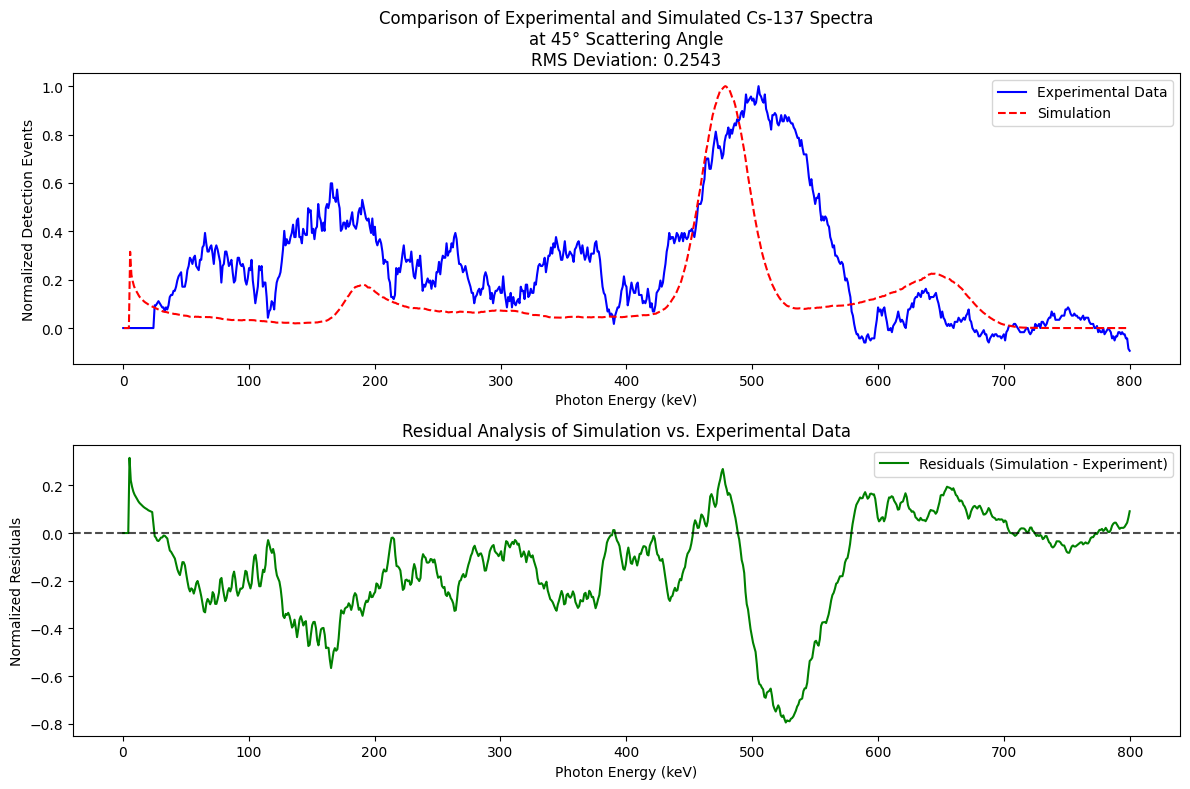

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Experimental Data ---
def load_and_smooth_experiment_data(window_size=10):
    """
    Load experimental data and smooth using a rolling average.
    :param window_size: Number of bins for smoothing.
    :return: Smoothed experimental data (with aluminum - no aluminum).
    """
    # Load experimental data
    with_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-with-shielding.csv')
    no_al_data = pd.read_csv('../data/experiment/1128/cs137-sspht022-2048bin-100s-2gain-45degree-no-aluminium-with-shielding.csv')
    
    # Sort data and reset index
    with_al_data = with_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    no_al_data = no_al_data.sort_values(by='Energy E / keV').reset_index(drop=True)
    
    # Subtract background
    subtracted_data = with_al_data.copy()
    subtracted_data['Events N'] = with_al_data['Events N'] - no_al_data['Events N']
    
    # Smooth data
    subtracted_data['Events N'] = subtracted_data['Events N'].rolling(window=window_size, center=True).mean()
    
    # Limit data range to 0–800 keV
    subtracted_data = subtracted_data[subtracted_data['Energy E / keV'] <= 800]

    # Replace NaN values with zeros
    subtracted_data = subtracted_data.fillna(0)
    
    return subtracted_data

# --- Load Simulation Data ---
def load_simulation_data():
    """
    Load simulation data from file.
    :return: Simulation bin centers and normalized counts.
    """
    # Load simulation data
    sim_data = pd.read_csv('data/simulation/study3/simulation_angle_45deg.csv')
    
    # Extract bin centers and counts
    bin_centers = sim_data['Energy (keV)'].values
    sim_data['Counts'] = sim_data['Counts'].rolling(window=10, center=True).mean()
    sim_data = sim_data.fillna(0)

    counts = sim_data['Counts'].values
    
    # Normalize counts
    counts_normalized = counts / np.max(counts)
    
    return bin_centers, counts_normalized

def calculate_rms_deviation(experimental_counts, simulation_counts):
    """
    Calculate RMS deviation between experimental and simulation data.
    """
    squared_diff = (experimental_counts - simulation_counts) ** 2
    rms = np.sqrt(np.mean(squared_diff))
    return rms

# --- Plotting ---
def plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts):
    """
    Plot experimental data, simulated data, and their difference.
    """
    # Interpolate experimental data to align with simulation bins
    experimental_counts = np.interp(simulation_bins, experiment_data['Energy E / keV'], experiment_data['Events N'])
    
    # Normalize both datasets
    experimental_counts_normalized = experimental_counts / np.max(experimental_counts)
    simulation_counts_normalized = simulation_counts / np.max(simulation_counts)
    
    # Calculate RMS deviation
    rms_deviation = calculate_rms_deviation(experimental_counts_normalized, simulation_counts_normalized)
    print(f"RMS Deviation: {rms_deviation:.4f}")
    
    # Calculate the difference (simulation - experiment)
    difference = simulation_counts_normalized - experimental_counts_normalized
    
    # Plot experiment and simulation
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(experiment_data['Energy E / keV'], experiment_data['Events N'] / np.max(experiment_data['Events N']),
             label='Experimental Data', color='blue')
    plt.plot(simulation_bins, simulation_counts_normalized, label='Simulation', color='red', linestyle='--')
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Detection Events')
    plt.title(f'Comparison of Experimental and Simulated Cs-137 Spectra\nat 45° Scattering Angle\nRMS Deviation: {rms_deviation:.4f}')
    plt.legend()
    
    # Plot difference
    plt.subplot(2, 1, 2)
    plt.plot(simulation_bins, difference, 
             label='Residuals (Simulation - Experiment)', color='green')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Photon Energy (keV)')
    plt.ylabel('Normalized Residuals')
    plt.title('Residual Analysis of Simulation vs. Experimental Data')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('study3_residual_plot', dpi=300)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Load and smooth experimental data
    experiment_data = load_and_smooth_experiment_data(window_size=50)
    
    # Load simulation data
    simulation_bins, simulation_counts = load_simulation_data()
    
    # Plot results
    plot_experiment_simulation_and_difference(experiment_data, simulation_bins, simulation_counts)


Sensitivity analysis complete. Check the output plots:
- sensitivity_thickness.png
- sensitivity_uncertainty.png
- sensitivity_metrics.png


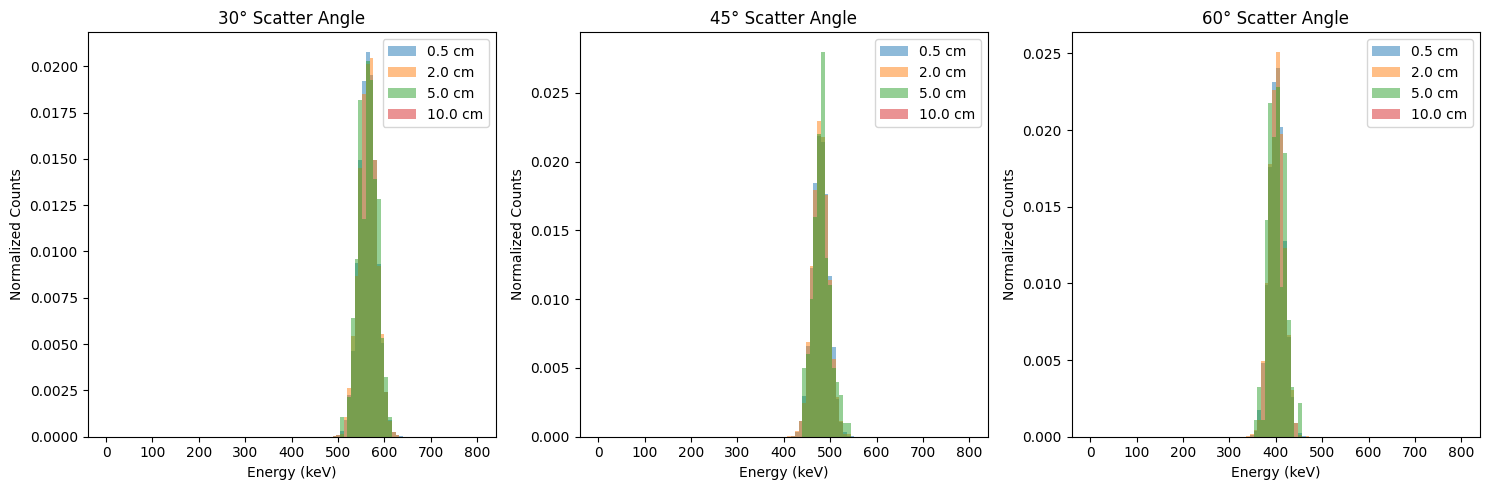

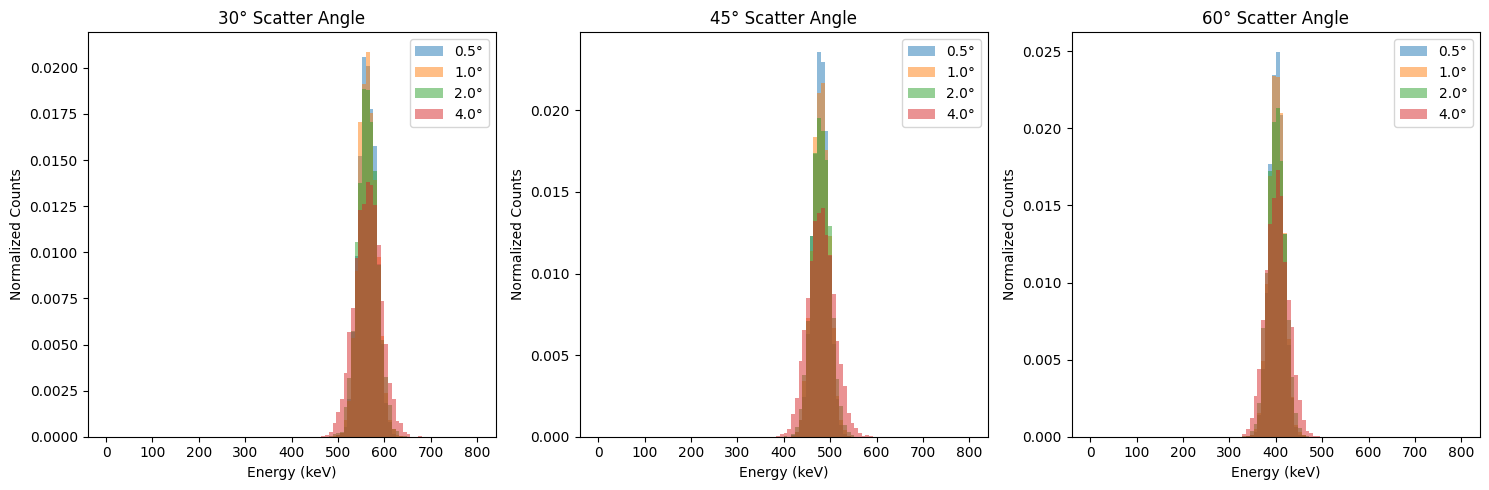

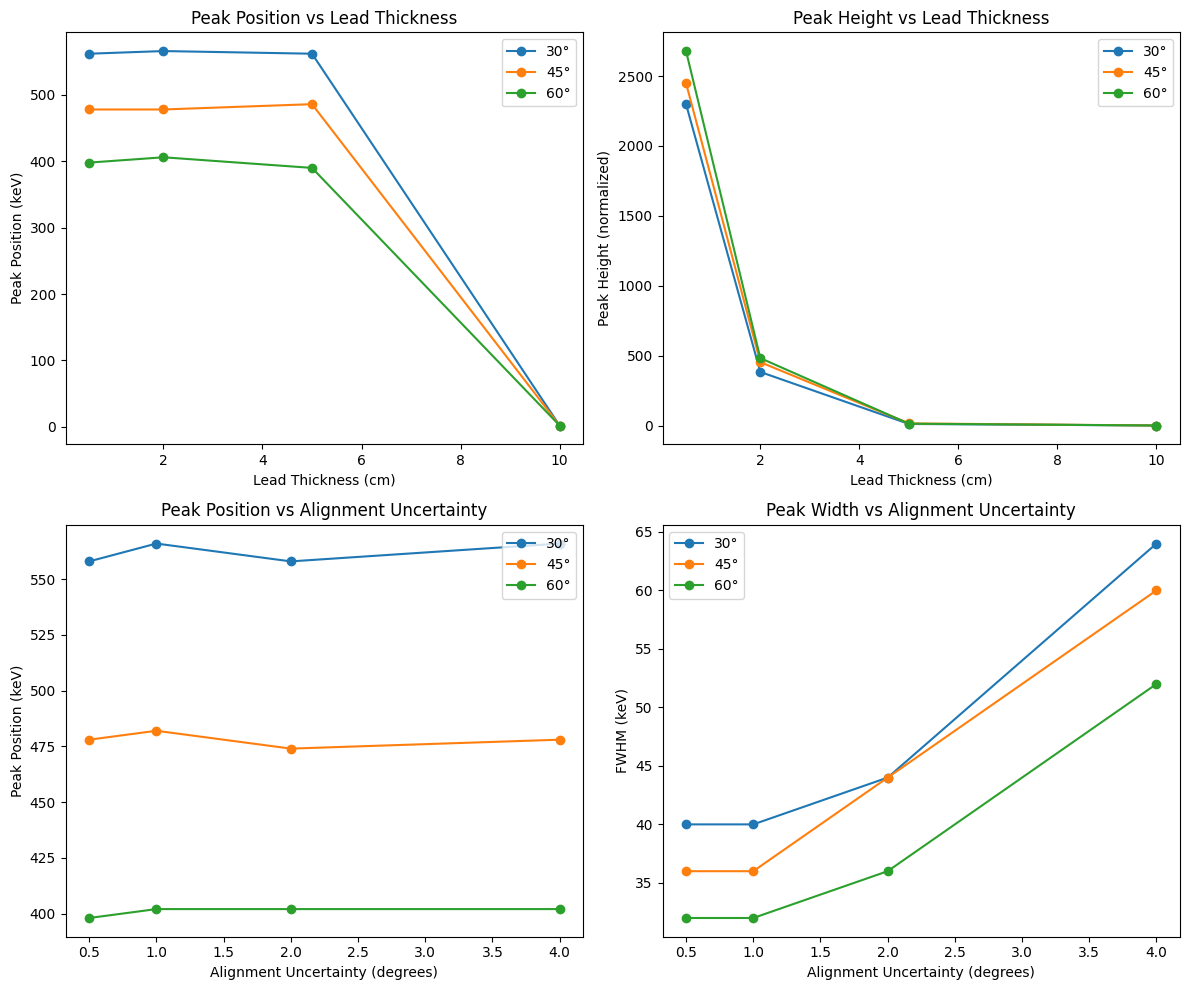

In [110]:
#!/usr/bin/env python3
"""
Sensitivity Analysis for Compton Scattering Simulation
---------------------------------------------------
"""

import numpy as np
import matplotlib.pyplot as plt

# Constants
E0 = 662  # keV, Cs-137 source

def compton_scattered_energy(E0, theta):
    """Calculate energy after Compton scatter."""
    return E0 / (1 + (E0/511.0)*(1 - np.cos(theta)))

def sample_theta_klein_nishina(E0, size=1):
    """Sample scattering angles from Klein-Nishina distribution."""
    thetas = np.random.uniform(0, np.pi, size=size*3)
    probs = np.random.uniform(0, 1, size=size*3)
    
    alpha = E0/511.0
    P = (1 + np.cos(thetas)**2)/2
    P *= (1 + alpha*(1 - np.cos(thetas)))**(-2)
    P *= (1 + alpha*(1 - np.cos(thetas))/((1 + np.cos(thetas)**2)))
    
    mask = probs < P/P.max()
    return thetas[mask][:size]

def gaussian_energy_smearing(energies, FWHM_at_662):
    """Apply Gaussian energy resolution."""
    sigma_at_662 = FWHM_at_662 * 662 / 2.355
    sigmas = sigma_at_662 * np.sqrt(energies/662)
    return np.random.normal(energies, sigmas)

def simulate_spectrum(E0, angle_deg, num_photons=50000, lead_thickness_cm=2.0, 
                     angle_uncertainty_deg=1.0):
    """Simulate Compton spectrum with given parameters."""
    angle_rad = np.radians(angle_deg)
    
    # Apply angle uncertainty
    angle_dev = np.random.normal(0, np.radians(angle_uncertainty_deg), num_photons)
    actual_angles = angle_rad + angle_dev
    
    # Calculate scattered energies
    energies = compton_scattered_energy(E0, actual_angles)
    
    # Apply lead attenuation
    mu_lead = 1.2  # cm^-1
    transmission_prob = np.exp(-mu_lead * lead_thickness_cm)
    mask = np.random.random(len(energies)) < transmission_prob
    energies = energies[mask]
    
    # Apply detector resolution
    energies = gaussian_energy_smearing(energies, FWHM_at_662=0.07)
    
    return energies

def calculate_peak_metrics(energies):
    """Calculate metrics for the spectrum."""
    hist, bins = np.histogram(energies, bins=200, range=(0, 800))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    peak_idx = np.argmax(hist)
    peak_height = hist[peak_idx]
    peak_position = bin_centers[peak_idx]
    
    half_max = peak_height / 2
    above_half = hist >= half_max
    left_idx = np.where(above_half)[0][0]
    right_idx = np.where(above_half)[0][-1]
    fwhm = bin_centers[right_idx] - bin_centers[left_idx]
    
    return peak_height, fwhm, peak_position

def sensitivity_analysis():
    """Perform sensitivity analysis."""
    lead_thicknesses = [0.5, 2.0, 5.0, 10.0]  # cm
    uncertainties = [0.5, 1.0, 2.0, 4.0]  # degrees
    angles = [30, 45, 60]  # degrees
    
    results = {'thickness': {}, 'uncertainty': {}}
    
    # 1. Lead Thickness Analysis
    plt.figure(figsize=(15, 5))
    for i, angle in enumerate(angles):
        plt.subplot(1, 3, i+1)
        peak_positions = []
        peak_heights = []
        
        for thickness in lead_thicknesses:
            spectra = simulate_spectrum(E0, angle, lead_thickness_cm=thickness,
                                     angle_uncertainty_deg=1.0)
            height, fwhm, position = calculate_peak_metrics(spectra)
            peak_positions.append(position)
            peak_heights.append(height)
            
            plt.hist(spectra, bins=100, range=(0, 800), 
                    alpha=0.5, label=f'{thickness} cm',
                    density=True)
        
        results['thickness'][angle] = {
            'positions': peak_positions,
            'heights': peak_heights
        }
        
        plt.title(f'{angle}° Scatter Angle')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Normalized Counts')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('sensitivity_thickness.png', dpi=300)
    
    # 2. Alignment Uncertainty Analysis
    plt.figure(figsize=(15, 5))
    for i, angle in enumerate(angles):
        plt.subplot(1, 3, i+1)
        peak_positions = []
        fwhm_values = []
        
        for uncertainty in uncertainties:
            spectra = simulate_spectrum(E0, angle, lead_thickness_cm=2.0,
                                     angle_uncertainty_deg=uncertainty)
            height, fwhm, position = calculate_peak_metrics(spectra)
            peak_positions.append(position)
            fwhm_values.append(fwhm)
            
            plt.hist(spectra, bins=100, range=(0, 800),
                    alpha=0.5, label=f'{uncertainty}°',
                    density=True)
        
        results['uncertainty'][angle] = {
            'positions': peak_positions,
            'fwhm': fwhm_values
        }
        
        plt.title(f'{angle}° Scatter Angle')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Normalized Counts')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('sensitivity_uncertainty.png', dpi=300)
    
    # Summary Metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    for angle in angles:
        ax1.plot(lead_thicknesses, results['thickness'][angle]['positions'],
                marker='o', label=f'{angle}°')
    ax1.set_xlabel('Lead Thickness (cm)')
    ax1.set_ylabel('Peak Position (keV)')
    ax1.legend()
    ax1.set_title('Peak Position vs Lead Thickness')
    
    for angle in angles:
        ax2.plot(lead_thicknesses, results['thickness'][angle]['heights'],
                marker='o', label=f'{angle}°')
    ax2.set_xlabel('Lead Thickness (cm)')
    ax2.set_ylabel('Peak Height (normalized)')
    ax2.legend()
    ax2.set_title('Peak Height vs Lead Thickness')
    
    for angle in angles:
        ax3.plot(uncertainties, results['uncertainty'][angle]['positions'],
                marker='o', label=f'{angle}°')
    ax3.set_xlabel('Alignment Uncertainty (degrees)')
    ax3.set_ylabel('Peak Position (keV)')
    ax3.legend()
    ax3.set_title('Peak Position vs Alignment Uncertainty')
    
    for angle in angles:
        ax4.plot(uncertainties, results['uncertainty'][angle]['fwhm'],
                marker='o', label=f'{angle}°')
    ax4.set_xlabel('Alignment Uncertainty (degrees)')
    ax4.set_ylabel('FWHM (keV)')
    ax4.legend()
    ax4.set_title('Peak Width vs Alignment Uncertainty')
    
    plt.tight_layout()
    plt.savefig('sensitivity_metrics.png', dpi=300)
    
    return results

if __name__ == "__main__":
    results = sensitivity_analysis()
    print("Sensitivity analysis complete. Check the output plots:")
    print("- sensitivity_thickness.png")
    print("- sensitivity_uncertainty.png")
    print("- sensitivity_metrics.png")
